# Diffusion equation

So far, we have always looked at ordinary differential equations, i.e. differential equations where the physical quantity we considered was depending only on one variable. In a lot of physical problems, the observable quantities depend on multiple variables like time and space. The differential equations, which govern those problems are partial differential equations. The diffusion equation is one of them. It pops up in various forms in physics, describing also heat conduction and in a slighly modified way this is corresponding to the time dependent Schrödinger equation. 

In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# default values for plotting
plt.rcParams.update({'font.size': 12,
                     'axes.titlesize': 18,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 10,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 


## Physical Model

The diffusion equation if given by

\begin{equation}
\frac{\partial c({\bf r},t)}{\partial t}=D\Delta c ({\bf r},t)
\end{equation}

If we give the quantity $c$ the meaning of a concentration, then the concentration will depend on space ${\bf r}$ and time $t$. $D$ is then the mass diffusion coefficient for example.


We want to tackle the solution of partial differential equations first in one dimension in space. Thus

\begin{equation}
\frac{\partial c(x,t)}{\partial t}=D\frac{\partial^2 c(x,t)}{\partial x^{2}}
\end{equation}

which looks a bit friendlier that before. In this equation, we have now two derivatives, one with respect to time and the other one with respect to position. According to ourt previous considerations in lecture 5, we need to discretize the concentration in space and time. We will therefore write $c^{n}_{i}$, where the index ${\bf n}$ **denotes the index in time** and ${\bf i}$ is the **index in space**.

### Spatial derivative

So, lets have a look at the positional derivative first. As we did previously already, we can approximate our second derivative by


\begin{equation}
\frac{\partial^{2} c(x,t)}{\partial x^2}\approx\frac{c_{i+1}^{n}-2c_{i}^{n}+c_{i-1}^{n}}{\Delta x^2}
\end{equation}


If we have now given the concentration in space at a time index $n$ by  ${\bf C}=\lbrace c_{0}^{n},c_{1}^{n},c_{2}^{n}, \ldots, c_{5}^{n}\rbrace$, then the second derivative in the finite difference scheme can be written in the implicit form by

$M=\frac{\partial^2c}{\partial x^2}=\frac{1}{\delta x^2}
\begin{bmatrix}
-2 & 1  & 0 & 0 & 0 & 0\\
 1 & -2 & 1 & 0 & 0 & 0\\
 0 & 1  & -2 & 1 & 0 & 0\\
 0 & 0  & 1  & -2 & 1 & 0\\
 0 & 0  & 0  &  1 & -2 & 1\\
 0 & 0  & 0  &  0 &  1 & -2\\
\end{bmatrix}
\begin{bmatrix}
c_{0}\\
c_{1}\\
c_{2}\\
c_{3}\\
c_{4}\\
c_{5}
\end{bmatrix}$

where we, of course, did not include any boundary conditions so far. 

In this case the diffusion equation can be written as

\begin{equation}
\frac{\partial c(x,t)}{\partial t}\approx DM{\bf C}^{n}
\end{equation}

where $M$ is the above matrix and ${\bf C}$ the concentration "vector". Note that the vector ${\bf C}$  still contains the index $n$, so the equation should be valid at each time index $n$.

### Temporal derivative

As a second step in our solution of the diffusion equation we now also discretize the temporal derivative. We do that by a simple forward derivative here. 

\begin{equation}
\frac{\partial c(x,t)}{\partial t}=\frac{c_{i}^{n+1}-c_{i}^{n}}{\delta t}
\end{equation}

Remember that we have to write that in terms of the index $n$ now, which is characterizing the discrete positions in time. Here, the solution is valid on each spatial position as characterized by the index $i$.



According to the Crank Nicolson scheme the time derivative 

\begin{equation}
\frac{\partial c}{\partial t} = f(x)
\end{equation}

which corresponds to a function $f(x)$, which is

\begin{equation}
f(x)=D\frac{\partial^2 c(x,t)}{\partial x^{2}}
\end{equation}

can be appxocimated by

\begin{equation}
\frac{\partial c}{\partial t} \approx \frac{1}{2}\left ( f^{n+1}(x)+f^{n}(x)\right)
\end{equation}

where $n$ is the index for the time.

### Bringing all together

We can now bring all sides together to develop our implicit scheme.


\begin{equation}
\frac{{\bf C^{n+1}}-{\bf C}^{n}}{\delta t}=\frac{1}{2} \left (D M {\bf C}^{n+1}+D M {\bf C}^{n} \right)
\end{equation}

We can transform the last equation to yield the value of of the concentration at the time index $n+1$, i.e. 


\begin{equation}
\left({\bf I}-\frac{\delta t}{2}D M \right ){\bf C}^{n+1}=\left({\bf I}+\frac{\delta t}{2}D M \right ){\bf C}^{n}
\end{equation}

where ${\bf I}$ is the identity matrix. This will correspond in our code to

\begin{equation}
{\bf A}{\bf C}^{n+1}={\bf B}{\bf C}^{n}
\end{equation}

where ${\bf A}=\left({\bf I}-\frac{\delta t}{2}D M \right )$ and ${\bf B}=\left({\bf I}+\frac{\delta t}{2}D M \right )$.

## Numerical Solution

We are now ready to write some code. The only thing we have to define are the boundary and initial condition.

We would like to simulate the diffusion in a domain $[0,L]$. The concentration at the boundaries shall be zero at all times,i.e.

\begin{equation}
c(0,t)=c(L,t)=0
\end{equation}

The initial condition for the concentration shall be a Gaussian centered at $x=L/2$. 

\begin{equation}
c(x,0)=\frac{1}{\sigma\sqrt{2\pi }}e^{-\frac{(x-L/2)^2}{2\sigma^2}}
\end{equation}

with $\sigma=0.05$ and $L=1$.

### Setup Domain

In [10]:
NT

1002

In [30]:
L=1.0 ## domain size

NX = 500 ## data points along position direction

dx = 1/(NX+1.0) ## position intervall
x = np.linspace(0,L,NX+2) ## position vector
x = x[1:-1] ## just skip the position at the beginning and end of the vector due to the boundary conditions
 
T = 0.5 ## time intervall
dt = dx/4 ## time step
NT = int(T/dt) ## number of time steps

D=1 ## diffusion coefficient

### Initial Conditions

In [31]:
sigma=0.02 ## initial distribution width
c = np.transpose(np.mat(np.exp(-(x-L/4)**2/(2*sigma**2)))) ## Gaussian distribution

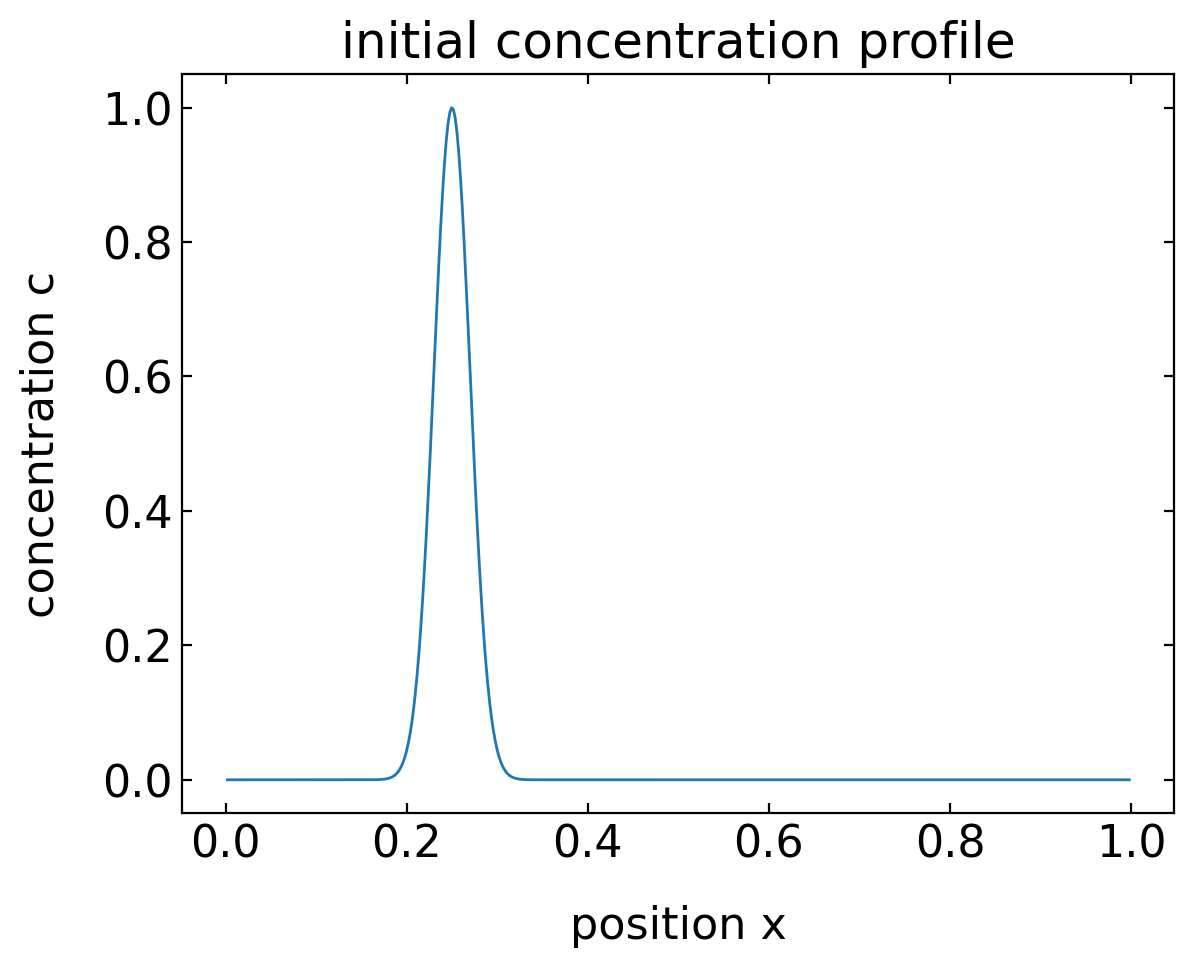

In [32]:
plt.xlabel('position x')
plt.ylabel('concentration c')
plt.title('initial concentration profile')
plt.plot(x,c)
plt.show()

### Matrix Setup

In [33]:
## Second derivative Matrix, this time created by spdiags of the scipy.sparse module
## the setup is a bit different from the scipy.diags, so we learn something new ;-)
data = np.ones((3, NX))
data[1] = -2*data[1]
diags = [-1,0,1]
M = sparse.spdiags(data,diags,NX,NX)/(dx**2)
 
# Identity Matrix
I = sparse.identity(NX)
 

In [34]:
M.todense()

matrix([[-502002.,  251001.,       0., ...,       0.,       0.,       0.],
        [ 251001., -502002.,  251001., ...,       0.,       0.,       0.],
        [      0.,  251001., -502002., ...,       0.,       0.,       0.],
        ...,
        [      0.,       0.,       0., ..., -502002.,  251001.,       0.],
        [      0.,       0.,       0., ...,  251001., -502002.,  251001.],
        [      0.,       0.,       0., ...,       0.,  251001., -502002.]])

### Solution

In [35]:
data = [] ## store the solutions for the individual timesteps
data.append(c)

for i in range(NT): ## loop over all timesteps

    A = (I -dt/2*D*M) ## matrix multiplied to the next timestep solution
    B = ( I + dt/2*D*M )*c ## matrix multiplied to the current timestep solution, which is c
    c = np.transpose(np.mat( sparse.linalg.spsolve( A,  B ) )) ## solve the system of linear equations
 
    data.append(c) ## store the solution

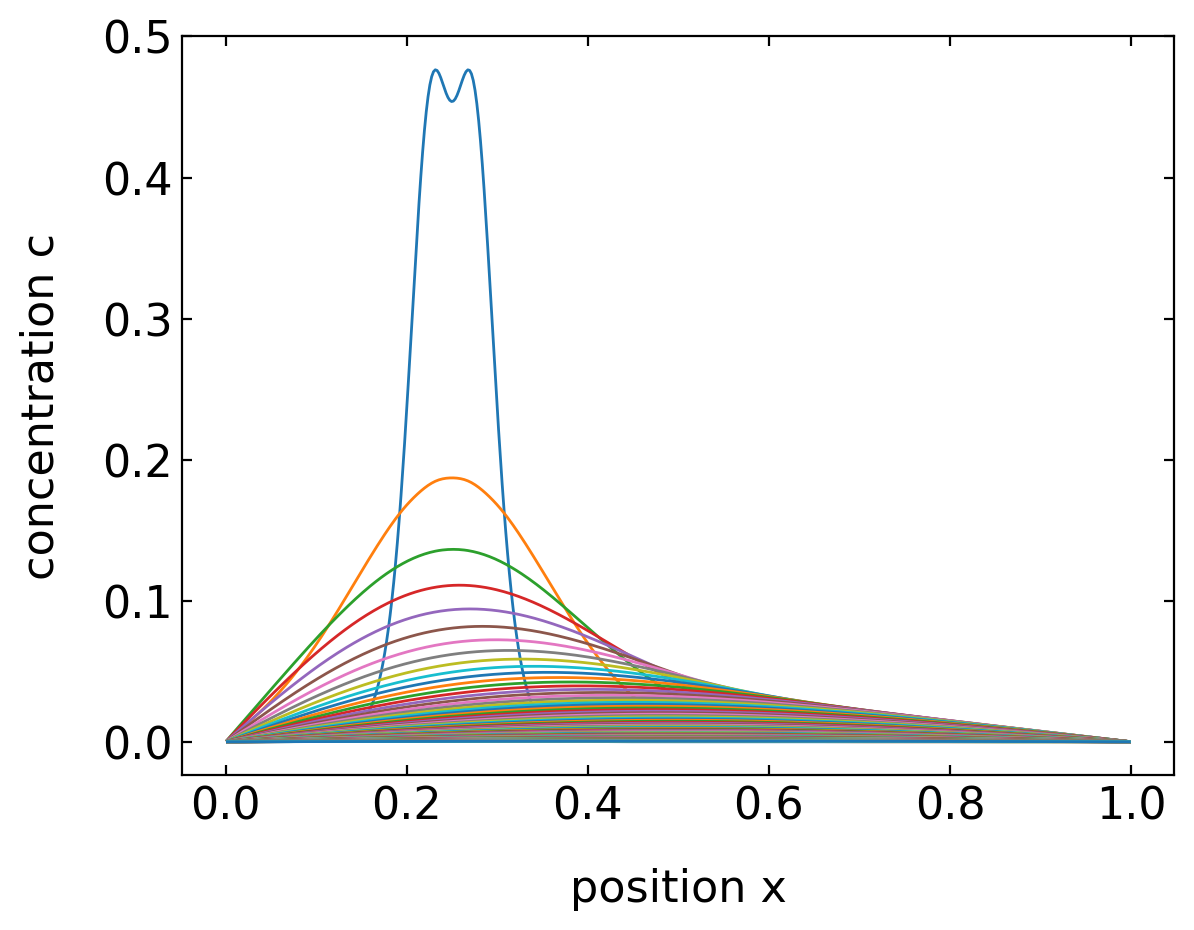

In [36]:
for i in range(1,NT,10):
    plt.plot(x,data[i])

plt.xlabel('position x')
plt.ylabel('concentration c')
plt.show()    

In [37]:
plt.imshow(np.array(data).reshape(NT,NX),vmin=0,vmax=0.1,cmap='gray_r',extent=(0,L,T,0))
plt.xlabel('position x')
plt.ylabel('time t')
plt.show()

ValueError: cannot reshape array of size 501500 into shape (1002,500)